In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 15)
pd.set_option('display.precision', 2)

In [2]:
# run this cell once
from sklearn.cross_validation import train_test_split

rest_reviews = pd.read_pickle('review/reviews300k.pkl')


# get restaurant reviews
#train_data, test_data = train_test_split(rest_reviews, test_size=0.3)


In [3]:
rest_reviews.shape


(295005, 15)

In [4]:
# deserialize train_data and test_data
train_data = pd.read_pickle('review/train_data_all.pkl')


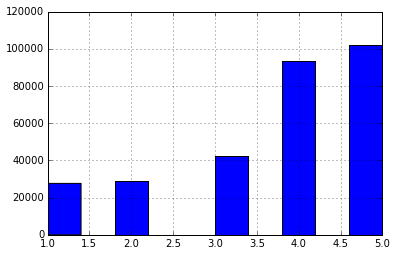

In [8]:
rest_reviews.stars.hist()

In [4]:
star_1 = rest_reviews[rest_reviews['stars']==1]
star_2 = rest_reviews[rest_reviews['stars']==2]
star_3 = rest_reviews[rest_reviews['stars']==3]
star_4 = rest_reviews[rest_reviews['stars']==4]
star_5 = rest_reviews[rest_reviews['stars']==5]

print star_1.shape
print star_2.shape
print star_3.shape
print star_4.shape
print star_5.shape

(27639, 15)
(29176, 15)
(42321, 15)
(93597, 15)
(102272, 15)


In [216]:
def df_info(df, transpose):
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    nan_df = pd.DataFrame(df.count(), columns=["# NaNs's"])
    nan_df["# NaNs's"] = nan_df["# NaNs's"].apply(lambda row: total_rows - row)
    print "Number of rows: %i" % total_rows
    print "Number of columns: %i" % total_cols
    print "Columns with NaN's:"
    if nan_df[nan_df["# NaNs's"]>0].empty:
        print 'None'
        return
    if transpose:
        print nan_df[nan_df["# NaNs's"]>0].T
    else:
        print nan_df[nan_df["# NaNs's"]>0]
    return

    

In [217]:
df_info(train_data, False)


Number of rows: 7000
Number of columns: 12
Columns with NaN's:
None


## LDA Model

In [23]:
def update(d, model, val, vectorizer):
    #vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))
    train_documents = d['text'].values
    train_matrix = vectorizer.transform(train_documents)
    corpus = matutils.Sparse2Corpus(train_matrix.T)
    
    corpora.MmCorpus.serialize('/tmp/corpus_all_'+str(val)+'.mm', corpus)
    corpus = corpora.MmCorpus('/tmp/corpus_all_'+str(val)+'.mm')
    model.update(corpus)
    model.save('/tmp/model_all_' + str(val) + '.mm')
    return

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
def run_lda(doc, starval):
    vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))
    train_documents = doc['text'].values
    train_matrix = vectorizer.fit_transform(train_documents)

    corpus = matutils.Sparse2Corpus(train_matrix.T)
    corpora.MmCorpus.serialize('/tmp/corpus_all_'+str(starval)+'.mm', corpus)
    corpus = corpora.MmCorpus('/tmp/corpus_all_'+str(starval)+'.mm')
    
    dictionary = vectorizer.vocabulary_
    gensim_dict = {}
    for key, val in dictionary.items():
        gensim_dict[val] = key
    
    lda = models.ldamodel.LdaModel(corpus, id2word=gensim_dict, num_topics=50)
    lda.save('/tmp/model_all_' + str(starval) + '.lda')
    return lda

In [10]:
lda_star_1 = run_lda(star_1, 1)

In [11]:
lda_star_2 = run_lda(star_2, 2)

In [12]:
lda_star_3 = run_lda(star_3, 3)

In [13]:
lda_star_4 = run_lda(star_4, 4)

In [14]:
lda_star_5 = run_lda(star_5, 5)

In [15]:
lda_star_1.save('/tmp/model_online_star_1.lda')
lda_star_2.save('/tmp/model_online_star_2.lda')
lda_star_3.save('/tmp/model_online_star_3.lda')
lda_star_4.save('/tmp/model_online_star_4.lda')
lda_star_5.save('/tmp/model_online_star_5.lda')

In [16]:
models = [lda_star_1, lda_star_2, lda_star_3, lda_star_4, lda_star_5]
dfs = []
for m in models:
    dfs.append(pd.DataFrame(m.show_topics(num_topics=50, formatted=False)))
    

In [30]:
formatted_dfs = []
for df in dfs:
    df = df.applymap(lambda x: x[1])
    lda_columns = map( lambda x: 'word_' + str(x), df.columns.values)
    df.columns = lda_columns
    df['words'] = map(list, df.values)
    formatted_dfs.append(df)


In [31]:
topics_1_star = formatted_dfs[0]
topics_2_star = formatted_dfs[1]
topics_3_star = formatted_dfs[2]
topics_4_star = formatted_dfs[3]
topics_5_star = formatted_dfs[4]


In [34]:
topics_2_star.to_pickle('by_stars/10ktopics_


,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,words
0,burger,fries,burgers,fox,good,like,frozen,roast,chili,bread,"[burger, fries, burgers, fox, good, like, froz..."
1,food,good,place,tacos,burrito,mexican,taco,like,fish,great,"[food, good, place, tacos, burrito, mexican, t..."
2,ribs,hopes,high hopes,good,small,price,just,portions,nice,small portions,"[ribs, hopes, high hopes, good, small, price, ..."
3,chicken,just,sauce,rice,ordered,pork,fried,dish,got,food,"[chicken, just, sauce, rice, ordered, pork, fr..."
4,breakfast,eggs,bacon,coffee,toast,pancakes,service,cooked,egg,potatoes,"[breakfast, eggs, bacon, coffee, toast, pancak..."


In [60]:
k = 0
topic_dict = {}
for val in df['words']:
    print 'Topic ' + str(k) + ':'
    print val
    topic_dict[k] = val
    k+=1


Topic 0:
[u'burger', u'fries', u'burgers', u'bacon', u'breakfast', u'pancakes', u'bun', u'waffle', u'fast', u'cheeseburger']
Topic 1:
[u'wine', u'cake', u'chocolate', u'dessert', u'perfectly', u'cooked', u'list', u'glass', u'enjoyed', u'evening']
Topic 2:
[u'cheese', u'bread', u'salad', u'pasta', u'italian', u'sauce', u'steak', u'mac', u'mac cheese', u'dessert']
Topic 3:
[u'room', u'downtown', u'dining room', u'walking', u'wood', u'fired', u'private', u'distance', u'best sushi', u'west']
Topic 4:
[u'chicken', u'salad', u'soup', u'rice', u'lunch', u'pita', u'greek', u'hummus', u'strip', u'gyro']
Topic 5:
[u'customer', u'customer service', u'al', u'valet', u'quick service', u'cool place', u'lunch spot', u'hi', u'green curry', u'crusted']
Topic 6:
[u'cuban', u'east valley', u'wonton', u'acceptable', u'pack', u'sour chicken', u'yep', u'palace', u'review place', u'tomorrow']
Topic 7:
[u'tea', u'iced', u'poor', u'iced tea', u'mins', u'employees', u'ready', u'attention', u'drinks food', u'ref

In [223]:
lda_model_50.save('/tmp/model_50.lda')

In [224]:
lda_model_50 = models.LdaModel.load('/tmp/model_50.lda')

In [226]:
lda_topics_50 = pd.DataFrame(lda_model_50.show_topics(num_topics=50, formatted=False))

## Apply model to test data set

### Prepare test reviews for model

In [61]:
test_data = pd.read_pickle('review/test_data_all.pkl')

documents_test = test_data['text'].values
m_test = vectorizer.transform(documents_test)



In [63]:
test_data.shape

(88502, 15)

In [72]:
s1 = test_data[0:20000]
s2 = test_data[20000:40000]
s3 = test_data[40000:60000]
s4 = test_data[60000:80000]
s5 = test_data[80000:]

docs = [s1, s2, s3, s4, s5]
i = 1
corpora_list = []
for doc in docs:
    doc_t = doc['text'].values
    doc_m = vectorizer.transform(doc_t)
    corpus_test = matutils.Sparse2Corpus(doc_m.T)
    
    corpora.MmCorpus.serialize('/tmp/corpus_test_all_' + str(i) + '.mm', corpus_test)
    corpus_test = corpora.MmCorpus('/tmp/corpus_test_all_' + str(i) + '.mm')
    corpora_list.append(corpus_test)
    i+=1



### Get the topics and topic probability distributions for our entire review data set

In [73]:
def get_topics(model, corpus):
    """ Takes a corpus and finds the topic id and word distribution of each document in the corpus.
        It returns a list of the topic ids and word distributions. """
    topic_id = []
    topic_prob = []
    word_dist = []
    corpus = list(corpus)
    for doc in corpus:
        topics = model[doc]
        topics_sorted = list(sorted(topics, key=lambda x:x[1]))
        topic_id.append(topics_sorted[-1][0]) # most related topic id
        topic_prob.append(topics_sorted[-1][1])
        word_dist.append(model.show_topic(topics_sorted[-1][0]))
    return topic_id, topic_prob, word_dist

In [74]:
test_topic_id = []
test_topic_prob = []
test_word_dist = []
for c in corpora_list:
    topic_id, topic_prob, word_dist = get_topics(lda_model, c)
    test_topic_id.append(topic_id)
    test_topic_prob.append(topic_prob)
    test_word_dist.append(word_dist)

KeyboardInterrupt: 

In [236]:
#serialize topic id/word distribution lists 
pd.DataFrame(test_topic_id).to_pickle('review/test_topic_id.pkl')
pd.DataFrame(test_topic_prob).to_pickle('review/test_topic_prob.pkl')
pd.DataFrame(test_word_dist).to_pickle('review/test_topic_dist.pkl')

In [237]:
test_data['topic_id_50'] = test_topic_id_50
test_data['topic_prob_50'] = test_topic_prob_50
test_data['word_dist_50'] = test_word_dist_50

test_data.to_pickle('review/train_data_topics.pkl')
test_data.head()

,business_id,review_id,date.year,date.month,date.day,stars,text,review_length,votes.cool,votes.funny,votes.useful,user_id,topic_id_50,topic_prob_50,word_dist_50
0,x_mxrJALBi5No9CxRswEaQ,KmZzQ5qPYxtSOZiS5rQJiQ,2011,5,19,3,This place is a little different than the over...,1557,1,0,1,p7dvahRPZIWL7T6pFA_0dg,39,0.2,"[(0.00977830773598, place), (0.00650128695031,..."
1,E4b5OC_6mZ0V7B6Nyjncsg,Jnt2z0W4hzc63qau4pCjIA,2010,11,23,4,4 1/2 stars - really great place! The decor i...,221,1,0,1,pEVf8GRshP9HUkSpizc9LA,3,0.2,"[(0.0153710636923, great), (0.0092647577608, p..."
2,3EAF9e45FH01odIIglru3g,_dpto8wcsvVEQQgTOX-YLQ,2013,10,4,5,The food was flavorful and the staff worked as...,93,0,0,0,4f6CdApcsdOPhcwSOmM4qw,46,0.3,"[(0.00681956996686, food), (0.00665234161418, ..."
3,_UOaoy1lcdIbgaA-d9dqpg,OpjIiDFhzi_kW_5veg_ZOw,2014,7,5,3,Mediocre sandwich place for sure. Place is cle...,205,0,0,0,grt5IJNerHdP4PMwc1cMdg,38,0.2,"[(0.0133049281147, good), (0.0124872546346, pl..."
4,LQGQ1w4pYrf5in6LrU0BlQ,TEJGrTBQX__79WwoBcJAnQ,2014,6,20,5,This place has been around for years and has t...,253,0,0,1,Ayx_wLGPjTVPIYoFerF82Q,48,0.6,"[(0.0146616328294, good), (0.0142812265826, fo..."


In [238]:
topic_id_50, topic_prob_50, word_dist_50 = get_topics(lda_model_50, corpus)

In [239]:
#serialize topic id/word distribution lists 
pd.DataFrame(topic_id_50).to_pickle('review/train_topic_id_50.pkl')
pd.DataFrame(topic_prob_50).to_pickle('review/train_topic_prob_50.pkl')
pd.DataFrame(word_dist_50).to_pickle('review/train_topic_dist_50.pkl')

In [240]:
train_data['topic_id_50'] = topic_id_50
train_data['topic_prob_50'] = topic_prob_50
train_data['word_dist_50'] = word_dist_50

train_data.to_pickle('review/train_data_topics.pkl')

train_data.head()


,business_id,review_id,date.year,date.month,date.day,stars,text,review_length,votes.cool,votes.funny,votes.useful,user_id,topic_id_50,topic_prob_50,word_dist_50
0,E7nk0lC317pGxMX56gvaVQ,onOLEBffcpWS_jcaBLCqdw,2008,6,17,1,This place is a huge waste of the space they m...,1239,3,4,2,eBFm-lABQiKpaUcPDfYOgA,39,0.6,"[(0.00977830773598, place), (0.00650128695031,..."
1,duHUQFn7K-Ybs1rPI4AOEQ,23z4mKkaMCXGFw4cm6xHxA,2012,4,15,3,I used to frequent Z-Tejas more frequently for...,936,1,1,2,y5_vrqIylhXMrejM_-x_vA,43,0.7,"[(0.0090865194881, good), (0.00526586990462, g..."
2,_K5cfCM7-zQZ1hXdbsc2fQ,dqrwXpcYdFvNYL5z1AeuZw,2013,12,1,3,"Meeting some friends for dinner, they live in ...",1119,0,0,0,8si1MT348c-rNZYDWCJvzQ,39,0.6,"[(0.00977830773598, place), (0.00650128695031,..."
3,OTq55xUFMOz13DAi9D0_rw,uiJbTytfC1zsSOQ4aA3AWg,2014,12,23,4,"Good food, and good service",27,0,0,1,YfWmj8wWbuiCbnC6D8gvpw,48,0.9,"[(0.0146616328294, good), (0.0142812265826, fo..."
4,Kfbs3K37ZczrOQnoxgzNkw,II7cxU1cbOxVqzYY4ueflQ,2012,1,25,4,Came here today to get lunch to go. They were ...,661,1,0,2,kffxYQVQsEpF1DVlQlcGCg,5,0.9,"[(0.0063096357766, food), (0.00550394162605, g..."


In [241]:
reviews = pd.concat([train_data, test_data], axis=0)
reviews.reset_index(inplace=True, drop=True)
print reviews.describe()
reviews.head()

       topic_id_50  topic_prob_50
count      10000.0        10000.0
mean          27.1            0.5
std           14.7            0.2
min            0.0            0.0
25%           15.0            0.3
50%           28.0            0.5
75%           39.0            0.6
max           49.0            1.0


,business_id,review_id,date.year,date.month,date.day,stars,text,review_length,votes.cool,votes.funny,votes.useful,user_id,topic_id_50,topic_prob_50,word_dist_50
0,E7nk0lC317pGxMX56gvaVQ,onOLEBffcpWS_jcaBLCqdw,2008,6,17,1,This place is a huge waste of the space they m...,1239,3,4,2,eBFm-lABQiKpaUcPDfYOgA,39,0.6,"[(0.00977830773598, place), (0.00650128695031,..."
1,duHUQFn7K-Ybs1rPI4AOEQ,23z4mKkaMCXGFw4cm6xHxA,2012,4,15,3,I used to frequent Z-Tejas more frequently for...,936,1,1,2,y5_vrqIylhXMrejM_-x_vA,43,0.7,"[(0.0090865194881, good), (0.00526586990462, g..."
2,_K5cfCM7-zQZ1hXdbsc2fQ,dqrwXpcYdFvNYL5z1AeuZw,2013,12,1,3,"Meeting some friends for dinner, they live in ...",1119,0,0,0,8si1MT348c-rNZYDWCJvzQ,39,0.6,"[(0.00977830773598, place), (0.00650128695031,..."
3,OTq55xUFMOz13DAi9D0_rw,uiJbTytfC1zsSOQ4aA3AWg,2014,12,23,4,"Good food, and good service",27,0,0,1,YfWmj8wWbuiCbnC6D8gvpw,48,0.9,"[(0.0146616328294, good), (0.0142812265826, fo..."
4,Kfbs3K37ZczrOQnoxgzNkw,II7cxU1cbOxVqzYY4ueflQ,2012,1,25,4,Came here today to get lunch to go. They were ...,661,1,0,2,kffxYQVQsEpF1DVlQlcGCg,5,0.9,"[(0.0063096357766, food), (0.00550394162605, g..."


In [242]:
reviews.to_pickle('review/reviews_with_topics.pkl')

## Exploring LDA results

In [137]:
lda_topics_50

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,"(0.00610489308015, food)","(0.00536757561738, good)","(0.00407210558982, place)","(0.0037431312672, rice)","(0.00249762288012, indian)","(0.0023008090173, chicken)","(0.00226198641757, don)","(0.00219456855018, like)","(0.00216307033037, just)","(0.00199229067994, salsa)"
1,"(0.0129114067986, place)","(0.0116924222419, great)","(0.0112452136997, good)","(0.0107805161015, food)","(0.00670595031098, like)","(0.00641820631365, service)","(0.00501210798395, just)","(0.00483569448915, time)","(0.00436332886908, love)","(0.00377175229072, restaurant)"
2,"(0.00482024992253, great)","(0.00402117446831, place)","(0.00345826404804, dinner)","(0.00320387107332, night)","(0.00319201633009, pizza)","(0.00301513124258, like)","(0.00300217517098, time)","(0.00277097118748, just)","(0.00223578453725, don)","(0.00211370537121, service)"
3,"(0.0122478146418, great)","(0.00847685287049, good)","(0.00770774232001, place)","(0.00726859093747, really)","(0.00657945483174, food)","(0.00501285720165, friendly)","(0.00428646314986, best)","(0.00423643914798, delicious)","(0.00391213578462, definitely)","(0.00332780040856, staff)"
4,"(0.0127397694348, good)","(0.0110781049463, food)","(0.00828138620365, place)","(0.00800788520933, service)","(0.00576006623028, like)","(0.00575683043354, great)","(0.00503840480225, just)","(0.00442527083608, time)","(0.00394435622523, prices)","(0.00375750128566, lunch)"
5,"(0.00762185033754, food)","(0.00620193877476, thai)","(0.00426970215983, place)","(0.00424966945538, gluten)","(0.00408212640407, just)","(0.00348116702214, gluten free)","(0.00314722764889, free)","(0.00281950205348, lunch)","(0.002809281615, pizza)","(0.00260482400031, good)"
6,"(0.00376568444605, food)","(0.00360777920371, great)","(0.00328579866505, cracker)","(0.00324694230131, best)","(0.00283001269011, barrel)","(0.00282731617065, cracker barrel)","(0.00236391769028, amazing)","(0.00226081352857, place)","(0.00223443136003, amazing service)","(0.00221074391305, good)"
...,...,...,...,...,...,...,...,...,...,...
43,"(0.0090672103597, great)","(0.00826641387396, good)","(0.00773953300729, food)","(0.00770465873369, really)","(0.00412142279461, place)","(0.00365576156661, service)","(0.00356290503472, like)","(0.00331689573432, salad)","(0.00328418103968, chicken)","(0.0030116276693, ve)"
44,"(0.0040568933221, food)","(0.0038477261844, place)","(0.00334582186228, great)","(0.00307092778043, soup)","(0.00290089436506, location)","(0.00285722341969, good)","(0.00275068899664, like)","(0.00244766961488, cheese)","(0.00198826485981, just)","(0.00185837308806, best)"


In [123]:
top_10_words_50 = []
for index, row in lda_topics_df.iterrows():
    words = []
    for val in row:
        words.append(val[1])
    top_10_words_50.append(words)


In [124]:
topics_words_50 = pd.DataFrame(top_10_words_50, columns=lda_topics_50.columns)
topics_words_50


,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,food,good,place,rice,indian,chicken,don,like,just,salsa
1,place,great,good,food,like,service,just,time,love,restaurant
2,great,place,dinner,night,pizza,like,time,just,don,service
3,great,good,place,really,food,friendly,best,delicious,definitely,staff
4,good,food,place,service,like,great,just,time,prices,lunch
5,food,thai,place,gluten,just,gluten free,free,lunch,pizza,good
6,food,great,cracker,best,barrel,cracker barrel,amazing,place,amazing service,good
...,...,...,...,...,...,...,...,...,...,...
43,great,good,food,really,place,service,like,salad,chicken,ve
44,food,place,great,soup,location,good,like,cheese,just,best


In [103]:
lda_model.show_topic(1)

[(0.01291140679858036, u'place'),
 (0.011692422241946748, u'great'),
 (0.01124521369970964, u'good'),
 (0.010780516101493305, u'food'),
 (0.0067059503109821172, u'like'),
 (0.0064182063136474796, u'service'),
 (0.0050121079839490733, u'just'),
 (0.0048356944891482104, u'time'),
 (0.0043633288690773479, u'love'),
 (0.0037717522907160629, u'restaurant')]

In [243]:
rest_reviews

,business_id,review_id,date.year,date.month,date.day,stars,text,review_length,votes.cool,votes.funny,votes.useful,user_id
0,9Ep4sguv3HH_8lWyzSogjw,owEJz2PJeyQiXELwDXgfqw,2009,8,18,4,Chomp chomp. Crunch crunch?\n\nWhy yes! That's...,1400,1,1,0,SIEb1KKCaH2CMrxt4azv1A
1,EHi-lebXGWjSktl4WvSoow,gkvyP2LoITViu8jXk5swgQ,2010,8,24,4,Jules was our server a few Wednesdays back for...,722,2,1,2,Q96IRvil6RNgdLmGKuh81A
2,1OA1jo0GlK9sf68f00w8ZQ,vla4f-IujCaYGkgIz6C01Q,2013,7,14,5,Great fast food place!! The prices can't be b...,218,0,0,0,-xPKyCJiK9q1OFZ7GCZwBw
3,KgTb63IZHFn_rhLG-cpm_A,h2RBvPYDFGCmxHX4PYNVAQ,2010,12,14,5,I heard from a friend that Renegade had become...,1682,2,0,3,oy6fdscGSXY2gzRqF9pZxg
4,IVKfggCQxQacIow9xP0fjA,I5abanoLK7QFkVkPiAvP9A,2013,12,11,4,Decide to try this place as I saw their menu a...,427,0,0,0,S3o_ekBuzmvnjFcTl_j6vg
5,VpHNYumY3F92a90AArkFyQ,5UkNQk8sCoBmQEVsagwA0g,2014,7,27,4,"For the price you pay, you get a decent amount...",243,0,0,0,uh8VYJuokQfjA-0CHUwQbg
6,fwYujhi514Ie5GsdIZsa2g,KRRlgdDwclxKI5V5qFQpTg,2014,10,2,5,They nailed it. Healthy food that tastes amazi...,1749,3,1,5,gzJpPaHN-NXBkAZcZri3hw
...,...,...,...,...,...,...,...,...,...,...,...,...
9993,svx5Gw-FJ6ZU9hb58aXgLg,HoeazfZb8QTRhDVqw83xKw,2014,8,18,5,This place never let's me down. Great food and...,172,0,0,1,_XKBfvm8QWOFJqKo87Ywrg
9994,jiWAo2z_seY5pQwhzrJiYA,w6gV9LYkdAxYQsKB2E_FTg,2013,9,29,4,Went in for just drinks w a large party. Staff...,479,0,0,0,Nsp_vUDdeinvlrTl1enHew


In [248]:
rest_reviews_all = pd.read_pickle('review/reviews300k.pkl')


# get restaurant reviews
train_data, test_data = train_test_split(rest_reviews_all, test_size=0.3)

In [249]:
train_data = pd.DataFrame(train_data, columns=rest_reviews_all.columns)
test_data = pd.DataFrame(test_data, columns=rest_reviews_all.columns)



In [251]:
vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))
train_documents = train_data['text'].values
train_matrix = vectorizer.fit_transform(train_documents)
corpus = matutils.Sparse2Corpus(train_matrix.T)

In [ ]:
corpora.MmCorpus.serialize('/tmp/corpus300k.mm', corpus)

In [ ]:
corpus = corpora.MmCorpus('/tmp/corpus300k.mm')